<center><a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05%20Deep%20Learning/notebooks/11-Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></center>

<h1>Autoencoders</h1>

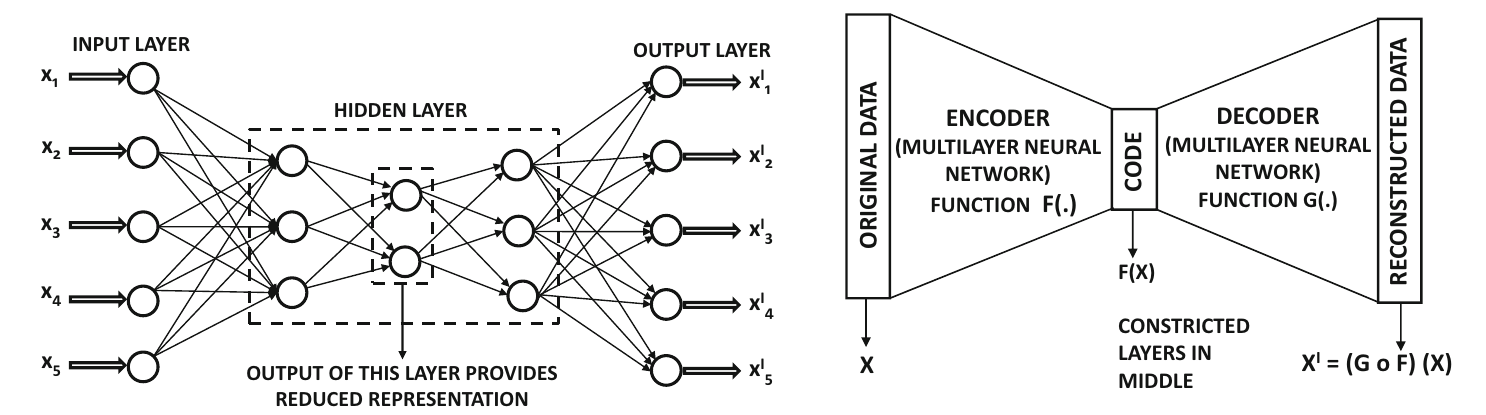


En esta notebook mostraremos varios usos de los autoencoders. En particular mostraremos su uso en tareas de

* *Denoising*
* Detección de anomalías
* Reducción de dimensionalidad

De manera paralela, mostraremos varias formas de definir su arquitectura, dependiendo de si queremos acceder individualmente al *encoder* y *decoder*.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo 1: Demostración básica con una MLP 

En este ejemplo mostramos un autoencoder muy sencillo basado en una MLP, con este módelo ilustraremos las diferentes partes del proceso: la codificación y la decodificación.

Para esto, usaremos el dataset MNIST de Keras. Entrenaremos un autoencoder para reconstruir la imágen de cada dígito. 

In [ ]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


Usaremos la clase `Model` para construir el autoencoder. Recordar que en esta clase tenemos que especificar cómo son las conexiones entre capas.

* Por un lado, crearemos la red *completa*, la cual entrenaremos con el conjunto de datos.
* Por otro lado, recuperaremos las capas *entrada-oculta* y *oculta-salida* para visualizar la reducción y la reconstrucción. 

El modelo completo

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

encoding_dim = 16

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

Compilamos el modelo

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

El encoder y decoder por separado.

In [ ]:
# ------ El encoder ------
encoder = Model(input_img, encoded)

# ------ El decoder ------
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1] # la última capa del modelo 'completo' autoencoder

decoder = Model(encoded_input, decoder_layer(encoded_input))

Agreagamos un `EarlyStopping`

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

Entrenamos el modelo, observa que el conjunto $X$, $y$ está formado por el mismo conjunto de imágenes. De igual manera, los datos de validación.

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs = 20,
                batch_size = 256,
                validation_data = (x_test, x_test),
                callbacks = [es])

Epoch 1/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0824 - val_loss: 0.0506
Epoch 2/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0432 - val_loss: 0.0373
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0349 - val_loss: 0.0321
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0308 - val_loss: 0.0288
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0281 - val_loss: 0.0267
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0265 - val_loss: 0.0256
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0256 - val_loss: 0.0248
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 9/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 10/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0232

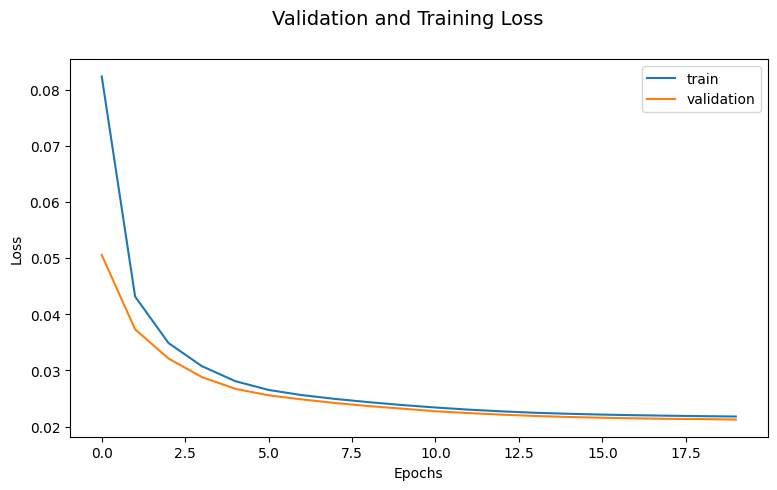

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Ahora, mostramos 5 imágenes aleatorias del conjunto de prueba. En cada una de ellas, mostramos la imágen original, la *imágen* codificada y la imágen reconstruida.

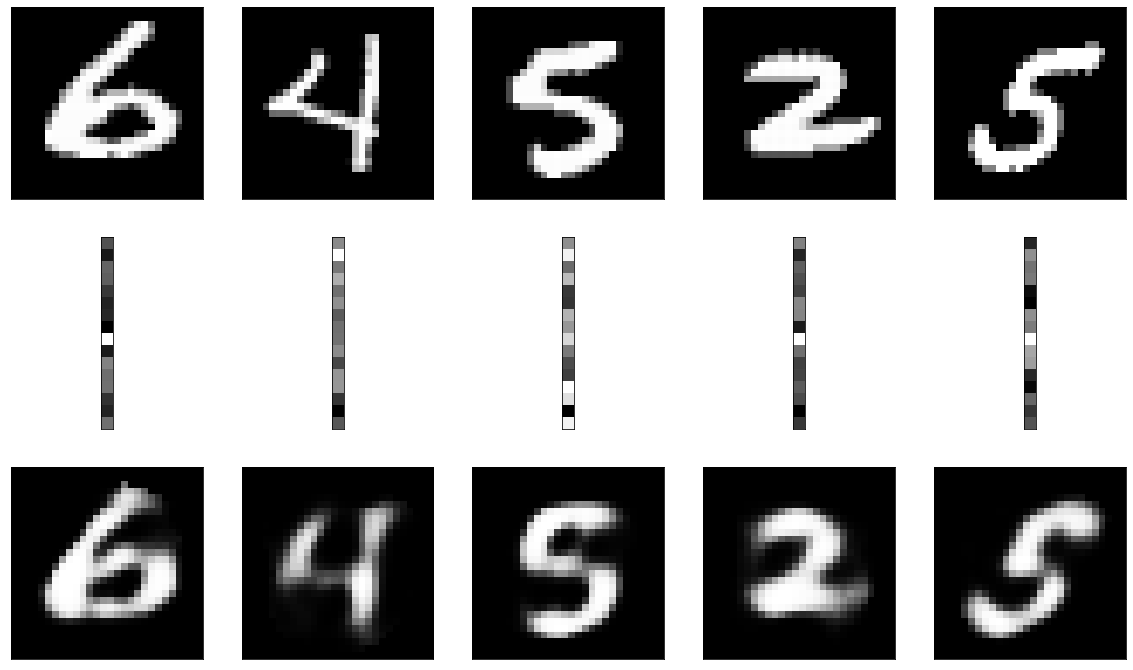

In [ ]:
# ------ Codificamos las imágenes ------
encoded_img = encoder.predict(x_test)
# ------ Decodificamos las imágenes codificada ------
decoded_img = decoder.predict(encoded_img)

# ------ Escogemos 5 imágenes aleatorias ------
m = x_test.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 12))
for i,idx in enumerate(idxs):
    # Mostrar original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar codificación latente
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(encoded_img[idx].reshape(encoding_dim, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(decoded_img[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Es importante notar que la codificación latente no es una versión comprimida de la imágen:

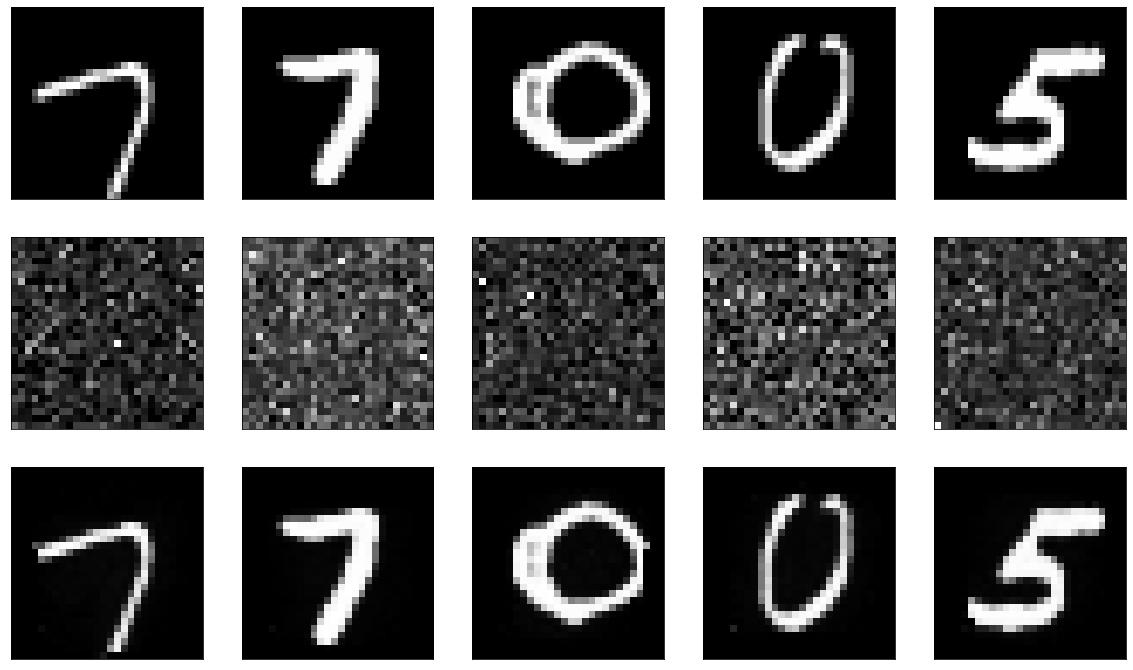

In [ ]:
import math

if math.modf(math.sqrt(encoding_dim))[0]==0:
    # ------ Escogemos 5 imágenes aleatorias ------
    m = x_test.shape[0]
    idxs = np.random.choice(m,size=5,replace=False)

    plt.figure(figsize=(20, 12))
    for i,idx in enumerate(idxs):
        # Mostrar original
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Mostrar codificación latente
        ax = plt.subplot(3, 5, i + 1 + 5)
        plt.imshow(encoded_img[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Mostrar reconstrucción
        ax = plt.subplot(3, 5, i + 1 + 10)
        plt.imshow(decoded_img[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
else:
    print("La dimensión de la codificación no es un cuadrado")

⭕ ¿Qué pasa si movemos el parámetro del número de neuronas en la capa oculta? ¿Qué pasa con las reconstrucciones?

## Denoising

Usaremos este mismo modelo entrenado para quitar el ruido de un imágen (denoising). Tomaremos imágenes de prueba y les añadiremos ruido, se las pasaremos a la red para que haga las predicciones.

In [ ]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
pred = autoencoder.predict(x_test_noisy)

Mostremos algunas imágenes aleatorias.

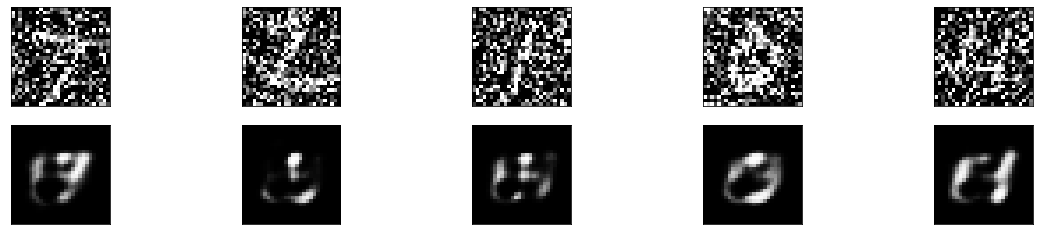

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Ejemplo 2: Demostración básica con un Autoencoder Convolucional 

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

Este modelo está basado en una CNN, por lo tanto ahora no nos interesará analizar las partes del encoder y decoder. Observa las capas de `UpSampling2D` ([documentación](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)), estas capas aumentan el tamaño de la imágen repitiendo los valores de pixeles. En este caso, el factor de aumento es 2. Es simétrico respecto al `MaxPooling2D` con factor 2.

Por otro lado, observa que la capa de salida es una capa convolucional de un sólo filtro. Por ser la salida y como nuestros valores de pixeles están re-escalados al intervalo $[0,1]$, tenemos una activación sigmoide.

Finalmente, siempre usamos `padding='same'` para no modificar el tamaño de las imágenes con los filtros de convolución.

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Sequential

model = Sequential()
# ------ encoder ------
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# ------ decoder ------
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # <--- capa de salida

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        300       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 15)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 15)          2040      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 15)       0

Entrenamos el modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
history = model.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                validation_data=(x_test, x_test),
                callbacks = [es])

Epoch 1/20
469/469 [==============================] - 13s 8ms/step - loss: 0.1274 - val_loss: 0.0781
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0764 - val_loss: 0.0739
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0736 - val_loss: 0.0721
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0722 - val_loss: 0.0710
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0712 - val_loss: 0.0701
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0705 - val_loss: 0.0698
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0700 - val_loss: 0.0692
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0696 - val_loss: 0.0690
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0692 - val_loss: 0.0685
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0690 - val_loss: 0.068

Curvas de entrenamiento

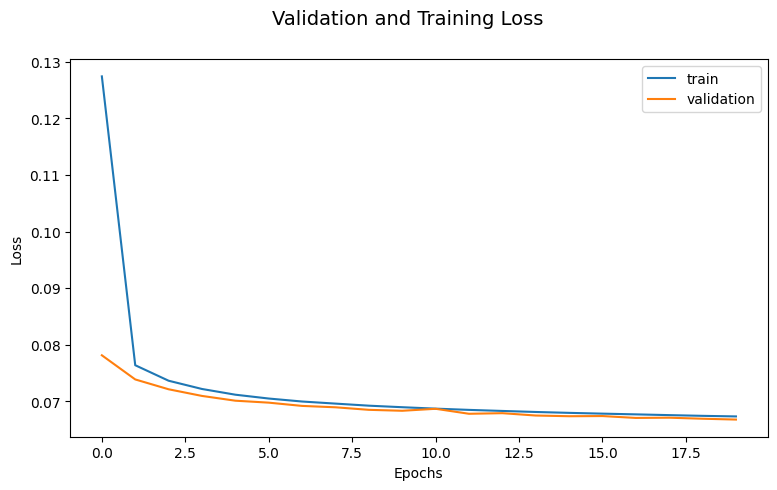

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Realizamos las predicciones

In [ ]:
pred = model.predict(x_test)

Algunos ejemplos mostrando la imágen original y la imagen reconstruida 

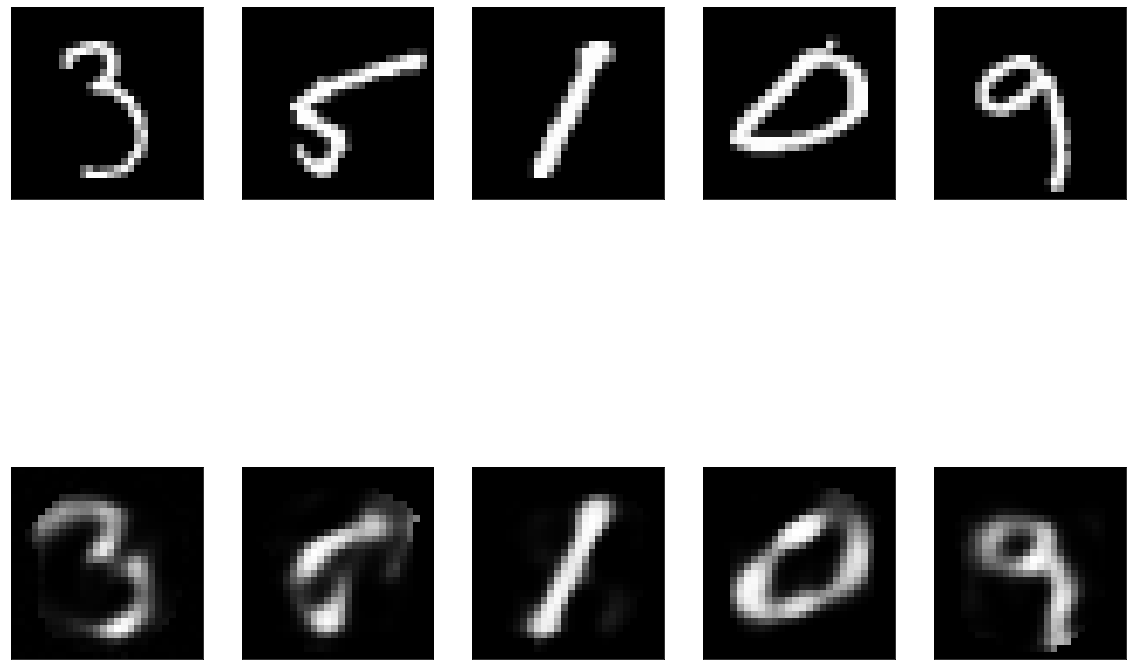

In [ ]:
# ------ Escogemos 5 imágenes aleatorias ------
m = x_test.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(15, 12))
for i,idx in enumerate(idxs):
    # Mostrar original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 5, i + 1 + 10)
    plt.imshow(decoded_img[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising pt. 1

En esta parte, repetimos la estrategia pasada para usar el autoencoder como herramienta de *denoising*. Es decir, usamos el modelo entrenado con las imágenes originales y hacemos las predicciones para las imágenes con ruido.

In [ ]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
pred = model.predict(x_test_noisy)

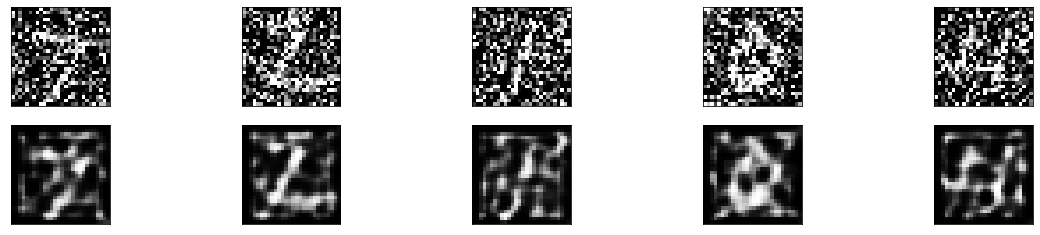

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos notar una mejoría. Ahora usaremos una mejor estrategia.

## Denoising pt. 2

Entrenaremos usando las imágenes con ruido y buscaremos que reconstruya las imágenes originales.

In [ ]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
model = Sequential()
# ------ encoder ------
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# ------ decoder ------
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.summary()

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 35)        350       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 25)        7900      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 25)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 25)          5650      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 25)      

Entrenamos el modelo

In [ ]:
history = model.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Epoch 1/15
469/469 [==============================] - 5s 9ms/step - loss: 0.1943 - val_loss: 0.1472
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1444 - val_loss: 0.1402
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1389 - val_loss: 0.1354
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1353 - val_loss: 0.1325
Epoch 5/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1327 - val_loss: 0.1308
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1308 - val_loss: 0.1288
Epoch 7/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1292 - val_loss: 0.1274
Epoch 8/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1280 - val_loss: 0.1274
Epoch 9/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1270 - val_loss: 0.1254
Epoch 10/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1261 - val_loss: 0.1245

Curvas de entrenamiento

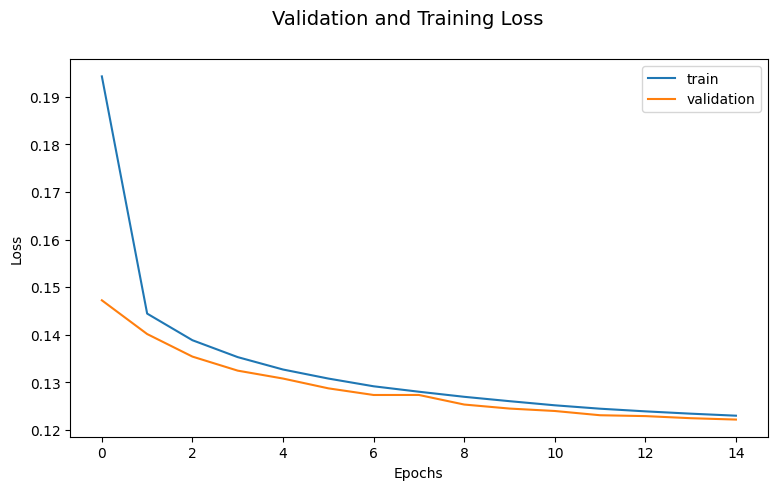

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Realizamos las predicciones

In [ ]:
pred = model.predict(x_test_noisy)

Veamos algunos ejemplos. Como se puede ver, ahora que la red ha sido entrenada con este propósito, se observan mejores resultados.

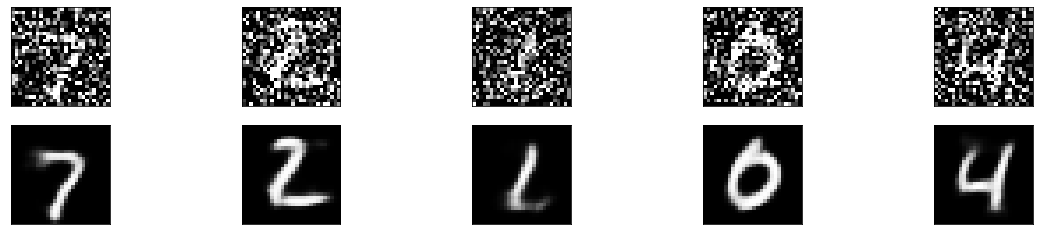

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Ejemplo 3: Anomaly Detection


Un electrocardiograma (ECG) es una prueba sencilla que permite comprobar el ritmo y la actividad eléctrica del corazón. El electrocardiograma registra las señales eléctricas del corazón y se usa para detectar con rapidez problemas cardíacos y controlar la salud del corazón.

El conjunto de datos original de "ECG5000" es un ECG de 20 horas de duración. A continuación, se seleccionaron aleatoriamente 5,000 latidos, cada uno con el mismo número de datos. El paciente tiene una insuficiencia cardíaca congestiva grave y los valores de clase se obtuvieron mediante una anotación automática.

**No usaremos los valores de clase para el entrenamiento**.

[Fuente del dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)

In [ ]:
#@title Traemos la carpeta 'data' de github

!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/05%20Deep%20Learning/data/"

A    data/airline-passengers.csv
A    data/diabetes.csv
A    data/ecg.csv
A    data/housing.data
A    data/img.png
A    data/mnist_biases1.npy
A    data/mnist_biases2.npy
A    data/mnist_weights1.npy
A    data/mnist_weights2.npy
Checked out revision 139.


Cargamos e inspeccionamos el dataframe

In [ ]:
import pandas as pd

df = pd.read_csv('data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Extraemos el conjunto de datos y las clases del dataframe

In [ ]:
raw_data = df.values

# ----- La matriz de valores de features -----
data = raw_data[:, 0:-1]

# ----- El vector de etiquetas -----
labels = raw_data[:, -1]

Separamos en conjunto de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.2, random_state=21)

X_train_original = X_train.copy()
X_test_original = X_test.copy()

Re-escalamos los datos con el rango de $X_{\text{train}}$. No podemos usar el `MinMaxScaler` de `scikit-learn` ya que en ese caso, cada columna tendría valores entre 0 y 1, es decir, perderiamos las relaciones entre valores de distintas columnas.

Observar que, como siempre, entrenamos con $X_{\text{train}}$ y a $X_{\text{test}}$ sólo lo transformamos en base al rango de $X_{\text{train}}$.

In [ ]:
from tensorflow import reduce_min, reduce_max, cast
from tensorflow import float32

min_val = reduce_min(X_train)   # Encontramos el mínimo valor sobre TODA la mátriz de datos
max_val = reduce_max(X_train)   # Encontramos el máximo valor sobre TODA la mátriz de datos

# ------ Re-escalamos sobre el rango de X_train ------
X_train = (X_train - min_val) / (max_val - min_val) 
X_test = (X_test - min_val) / (max_val - min_val)

# ------ Pasamos los datos al tipo tf.float ------
train_data = cast(X_train, float32)
X_test = cast(X_test, float32)

## Analicemos qué pasa si usamos el `MinMaxScaler`

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scl = MinMaxScaler()
X_train_minmax = scl.fit_transform(X_train_original)
X_test_minmax = scl.transform(X_test_original)

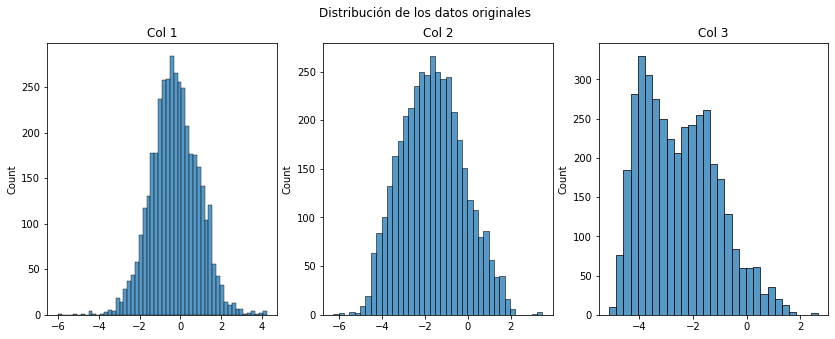

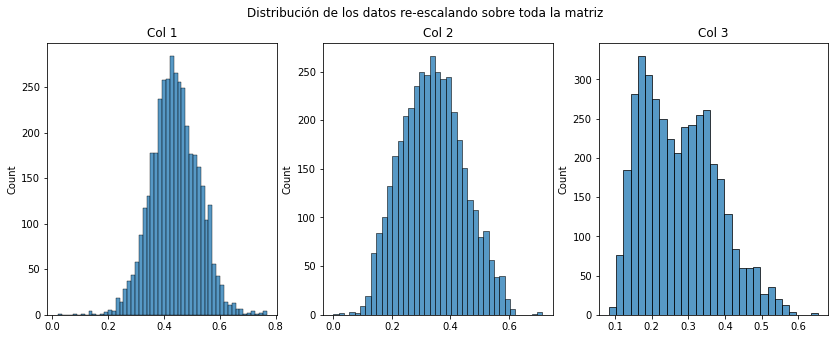

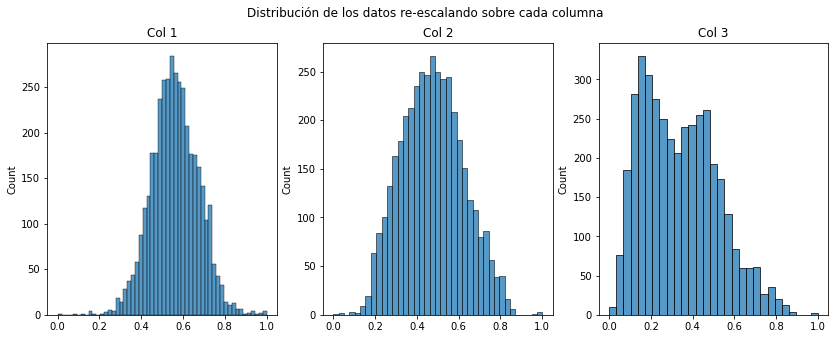

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5)) 
plt.suptitle("Distribución de los datos originales")
for j in range(3):
    ax = plt.subplot(1, 3, j + 1)
    ax.title.set_text(f"Col {j+1}")           
    sns.histplot(X_train_original[:,j],ax=ax)
plt.show()

plt.figure(figsize=(14,5)) 
plt.suptitle("Distribución de los datos re-escalando sobre toda la matriz")
for j in range(3):
    ax = plt.subplot(1, 3, j + 1)    
    ax.title.set_text(f"Col {j+1}")          
    sns.histplot(X_train[:,j],ax=ax)
plt.show()

plt.figure(figsize=(14,5)) 
plt.suptitle("Distribución de los datos re-escalando sobre cada columna")
for j in range(3):
    ax = plt.subplot(1, 3, j + 1)    
    ax.title.set_text(f"Col {j+1}")          
    sns.histplot(X_train_minmax[:,j],ax=ax)
plt.show()

## Continuemos con el ejercicio

Separamos los datos que contienen ECG normales y anómalos.

In [ ]:
# ------ Cambiamos el vector de etiquetas a booleano ------
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# ------ Separamos los datos de entrenamiento y prueba ------
normal_train_data = X_train[y_train]
normal_test_data = X_test[y_test]

anomalous_train_data = X_train[~y_train]
anomalous_test_data = X_test[~y_test]

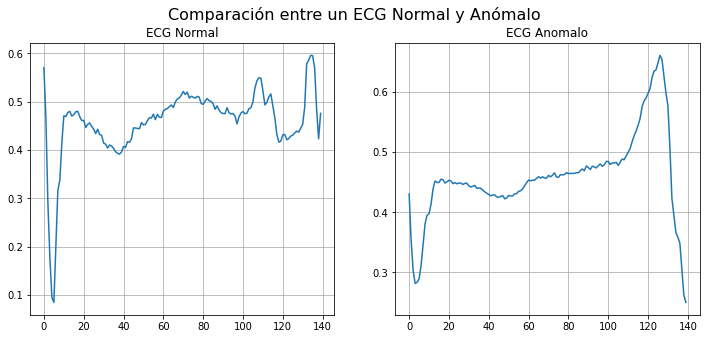

In [ ]:
plt.figure(figsize=(12, 5))
plt.suptitle("Comparación entre un ECG Normal y Anómalo",fontsize=16)
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("ECG Anomalo")
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(32, activation="relu",input_shape=(140,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(140, activation="sigmoid"))

model.compile(optimizer='adam', loss='mae')

In [ ]:
history = model.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 39ms/step - loss: 0.0579 - val_loss: 0.0530
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0555 - val_loss: 0.0515
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0526 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0491 - val_loss: 0.0475
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0454 - val_loss: 0.0454
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0416 - val_loss: 0.0431
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0378 - val_loss: 0.0414
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0343 - val_loss: 0.0395
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0312 - val_loss: 0.0379
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0286 - val_loss: 0.0368
Epoch 11/20
5/5 [====================

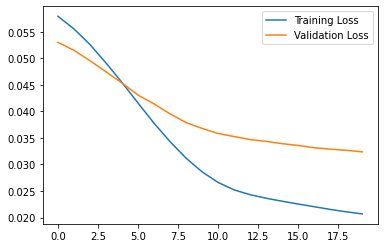

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

Realizamos las predicciones, tanto con los datos *normales* como con los datos *anómalos*.

In [ ]:
predictions_normal = model.predict(normal_test_data)
predictions_anom = model.predict(anomalous_test_data)

Calculamos las perdidas en cada uno de los dos casos. Esta función `mae` nos regresa el arreglo de todas las perdidas individuales.

In [ ]:
from tensorflow.keras.losses import mae

test_loss_normal = mae(predictions_normal, normal_test_data).numpy()
test_loss_anom = mae(predictions_anom, anomalous_test_data).numpy()

In [ ]:
test_loss_normal.shape

(560,)

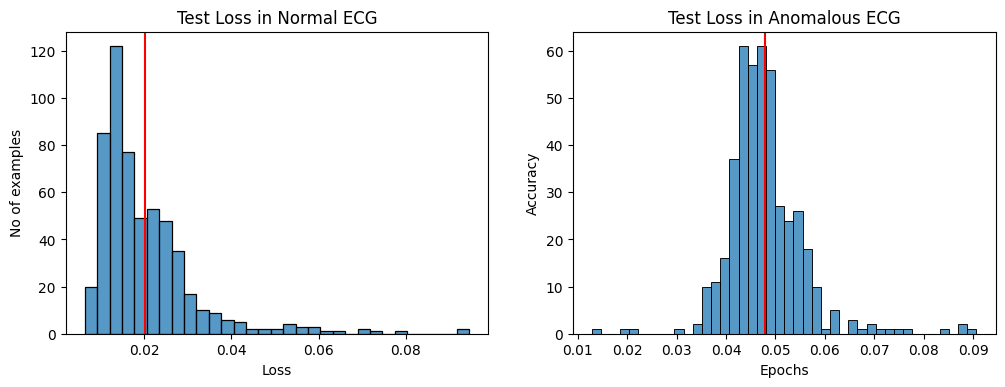

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 4),dpi=100)
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Test Loss in Normal ECG")
sns.histplot(test_loss_normal, ax=ax)
plt.axvline(x=np.mean(test_loss_normal),c='red')
plt.xlabel("Loss")
plt.ylabel("No of examples")
ax = plt.subplot(1, 2, 2)
ax.title.set_text("Test Loss in Anomalous ECG")
sns.histplot(test_loss_anom, ax=ax)
plt.axvline(x=np.mean(test_loss_anom),c='red')
plt.xlabel("Loss")
plt.ylabel("No of examples")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Ejemplo con un ECG Normal

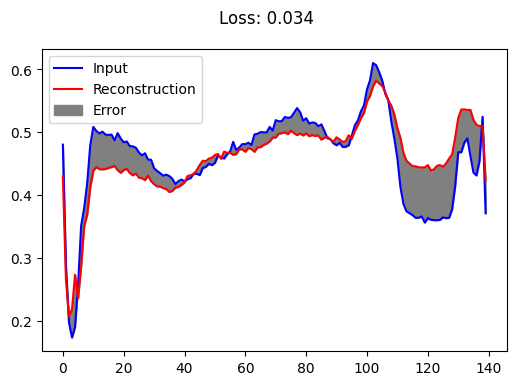

In [ ]:
plt.figure(dpi=100)
plt.suptitle("Loss: {:.3f}".format(test_loss_normal[0]))
plt.plot(normal_test_data[0], c='b')
plt.plot(predictions_normal[0], c='r')
plt.fill_between(np.arange(140), predictions_normal[0], normal_test_data[0], color='gray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Ejemplo con un ECG anómalo, podemos ver que el error (perdida) es mayor en esta predicción.

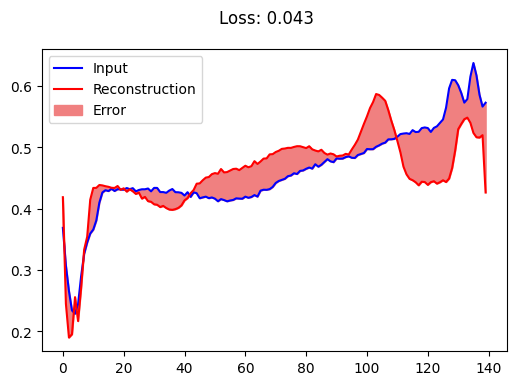

In [ ]:
plt.figure(dpi=100)
plt.suptitle("Loss: {:.3f}".format(test_loss_anom[0]))
plt.plot(anomalous_test_data[0], c='b')
plt.plot(predictions_anom[0], c='r')
plt.fill_between(np.arange(140), predictions_anom[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Exploremos ahora la pérdida en el conjunto de entrenamiento. Definiremos un umbral $p$, una desviación standard arriba del promedio. Este valor fue considerado arbitrariamente.

Threshold: 0.032


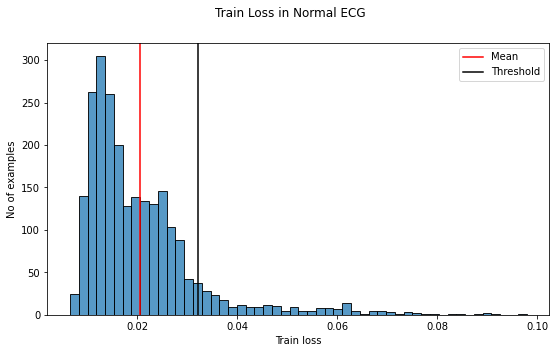

In [ ]:
from tensorflow.keras.losses import mae

# ----- Calculamos las pérdidas de entrenamiento -----
train_predictions = model.predict(normal_train_data)
train_loss = mae(train_predictions, normal_train_data).numpy()

# ----- Calculamos el umbral -----
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: {:.3f}".format(threshold))

# ----- Graficamos -----
plt.figure(figsize=(9,5))
plt.suptitle("Train Loss in Normal ECG")
sns.histplot(train_loss)
plt.axvline(x=np.mean(train_loss),c='red', label='Mean')
plt.axvline(x=threshold,c='black', label='Threshold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend(loc='best')
plt.show()

Ahora, definiremos una función para predecir la clase de cada ECG. La función está dada por

\begin{align}
        f(x) = \left\{
        \begin{array}{cl}
        1 & x \leq \text{threshold} \\
        0 & x > \text{threshold}.
        \end{array}
        \right.
    \end{align}

In [ ]:
from tensorflow.keras.losses import mae
from tensorflow.math import less

def predict_label(model, data, threshold):
    '''
    Esta función predice la etiqueta de los datos a partir del umbrar que definimos
    '''
    predictions = model(data)
    loss = mae(predictions, data)
    return less(loss, threshold)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

predicted_labels = predict_label(model=model,
                                 data=X_test,
                                 threshold=threshold) 

print("Accuracy = {:.3f}".format(accuracy_score(y_test, predicted_labels)))
print("Precision = {:.3f}".format(precision_score(y_test, predicted_labels)))
print("Recall = {:.3f}".format(recall_score(y_test, predicted_labels)))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, predicted_labels)}")

Accuracy = 0.944
Precision = 0.992
Recall = 0.907
Confusion Matrix:
[[436   4]
 [ 52 508]]


⭕ Ejercicio: Prueba arquitecturas más profundas para este ejercicio, ¿puedes subir el rendimiento?

✨ Algunas observaciones:

* Dado que no nos interesa predecir (reconstruir) los ECG originales, no hubo necesidad de re-escalar a la escala original de los datos.
* El objetivo de este autoencoder es detectar anomalías en los ECG.

# Ejemplo 4: Dimensionality Reduction

En este ejemplo mostraremos cómo usar los autoencoders como herramientas de reducción de dimensionalidad. 

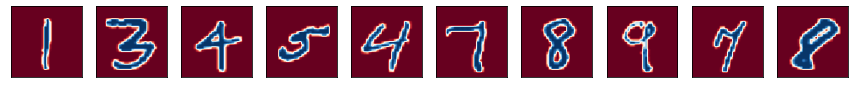

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# ----- Cargamos el conjunto de datos MNIST -----
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# ----- Normalizamos los valores de pixeles al intervalo [0,1] -----
x_train = x_train/255.
x_test = x_test/255.

# ----- Como siempre, mostramos algunos ejemplos -----
idxs = np.random.choice(range(x_train.shape[0]), size=10, replace=False)
plt.figure(figsize=(15,4))
for i,idx in enumerate(idxs):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_train[idx].reshape(28,28),cmap='RdBu');
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential, Model

# ----- Dimensión Latente del Espacio de Codificación -----
latent_dim = 2

img_shape = (x_train.shape[1], x_train.shape[2])

encoder = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, name='encoder_output',activation='sigmoid')
])

decoder = Sequential([
    Dense(32, activation='relu', input_shape=(latent_dim,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(img_shape[0] * img_shape[1], activation='relu'),
    Reshape(img_shape)
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Opcional: Definir un callback propio

A continuación se muestra cómo definir un callback propio. Este callback grafica la representación latente 2-dimensional en cada época. 

* Guía para hacer callbacks propios: https://keras.io/guides/writing_your_own_callbacks/
* Código de la clase general `tensorflow.keras.callbacks.Callback`: https://github.com/keras-team/keras/blob/v2.9.0/keras/callbacks.py#L576

In [ ]:
import tensorflow
import numpy as np

class SaveEncodings(tensorflow.keras.callbacks.Callback):
    def __init__(self, x_test, y_test,fname):
        super(SaveEncodings, self).__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.fname = fname
        self.tensor = []
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch = self.current_epoch + 1
        encoder_model = Model(inputs=self.model.input,
                              outputs=self.model.get_layer('encoder_output').output)
        encoder_output = encoder_model(self.x_test)
        self.tensor.append(encoder_output)

    def on_train_end(self, logs=None):
        """Called at the end of training.
        Subclasses should override for any actions to run.
        Args:
            logs: Dict. Currently the output of the last call to `on_epoch_end()`
            is passed to this argument for this method but that may change in
            the future.
        """
        X = np.array(self.tensor)
        np.save(self.fname,X)

In [ ]:
pe = SaveEncodings(x_test[:500],y_test[:500],"tensor.npy")

## Continuamos con el entrenamiento

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, mode='min')

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=32, verbose=2
                                , callbacks=[es,pe]
                                , validation_split=0.1
                                )

Epoch 1/15
1688/1688 - 7s - loss: 0.6459 - val_loss: 0.5419 - 7s/epoch - 4ms/step
Epoch 2/15
1688/1688 - 5s - loss: 0.5174 - val_loss: 0.4863 - 5s/epoch - 3ms/step
Epoch 3/15
1688/1688 - 5s - loss: 0.4545 - val_loss: 0.4420 - 5s/epoch - 3ms/step
Epoch 4/15
1688/1688 - 5s - loss: 0.4455 - val_loss: 0.4446 - 5s/epoch - 3ms/step
Epoch 5/15
1688/1688 - 5s - loss: 0.4394 - val_loss: 0.4326 - 5s/epoch - 3ms/step
Epoch 6/15
1688/1688 - 5s - loss: 0.4356 - val_loss: 0.4365 - 5s/epoch - 3ms/step
Epoch 7/15
1688/1688 - 5s - loss: 0.4349 - val_loss: 0.4289 - 5s/epoch - 3ms/step
Epoch 8/15
1688/1688 - 5s - loss: 0.4360 - val_loss: 0.4421 - 5s/epoch - 3ms/step
Epoch 9/15
1688/1688 - 5s - loss: 0.4360 - val_loss: 0.4284 - 5s/epoch - 3ms/step
Epoch 10/15
1688/1688 - 5s - loss: 0.4376 - val_loss: 0.4319 - 5s/epoch - 3ms/step
Epoch 11/15
1688/1688 - 5s - loss: 0.4355 - val_loss: 0.4277 - 5s/epoch - 3ms/step
Epoch 12/15
1688/1688 - 5s - loss: 0.4397 - val_loss: 0.4409 - 5s/epoch - 3ms/step
Epoch 13/15
1

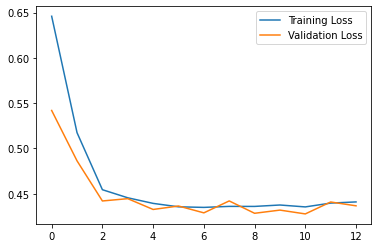

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# ----- Aplicamos PCA -----
pca = PCA(n_components=2)
x_reshaped = x_test[0:500].reshape(-1, 784)              
x_transformed = pca.fit_transform(x_reshaped)

# ----- Obtenemos la representación reducida de la red -----
x_dimred = encoder.predict(x_test[0:500])

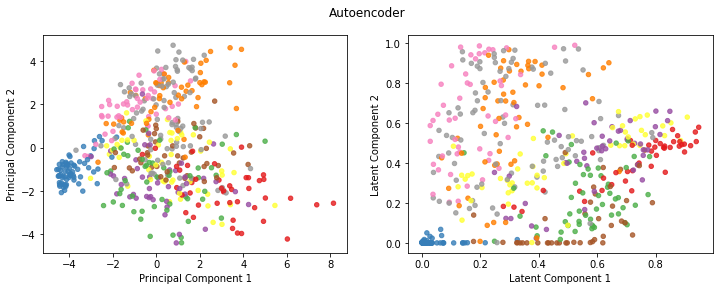

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle("Comparación entre PCA y AE",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("PCA")
plt.scatter(x_transformed[:, 0], x_transformed[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.subplot(1, 2, 2)
plt.suptitle("Autoencoder")
plt.scatter(x_dimred[:, 0], x_dimred[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Latent Component 1')
plt.ylabel('Latent Component 2')
plt.show()

Ahora, exploremos la evolución de las representaciones latentes. Primero, carguemos el tensor de numpy que las contiene, este fue generado por nuestro callback. Debe tener la forma:

$$\text{Número de épocas}\times\text{Ejemplos}\times 2$$

In [ ]:
representaciones = np.load("tensor.npy")
representaciones.shape

(13, 500, 2)

Graficamos las representaciones 2-dimensionales a lo largo del entrenamiento.

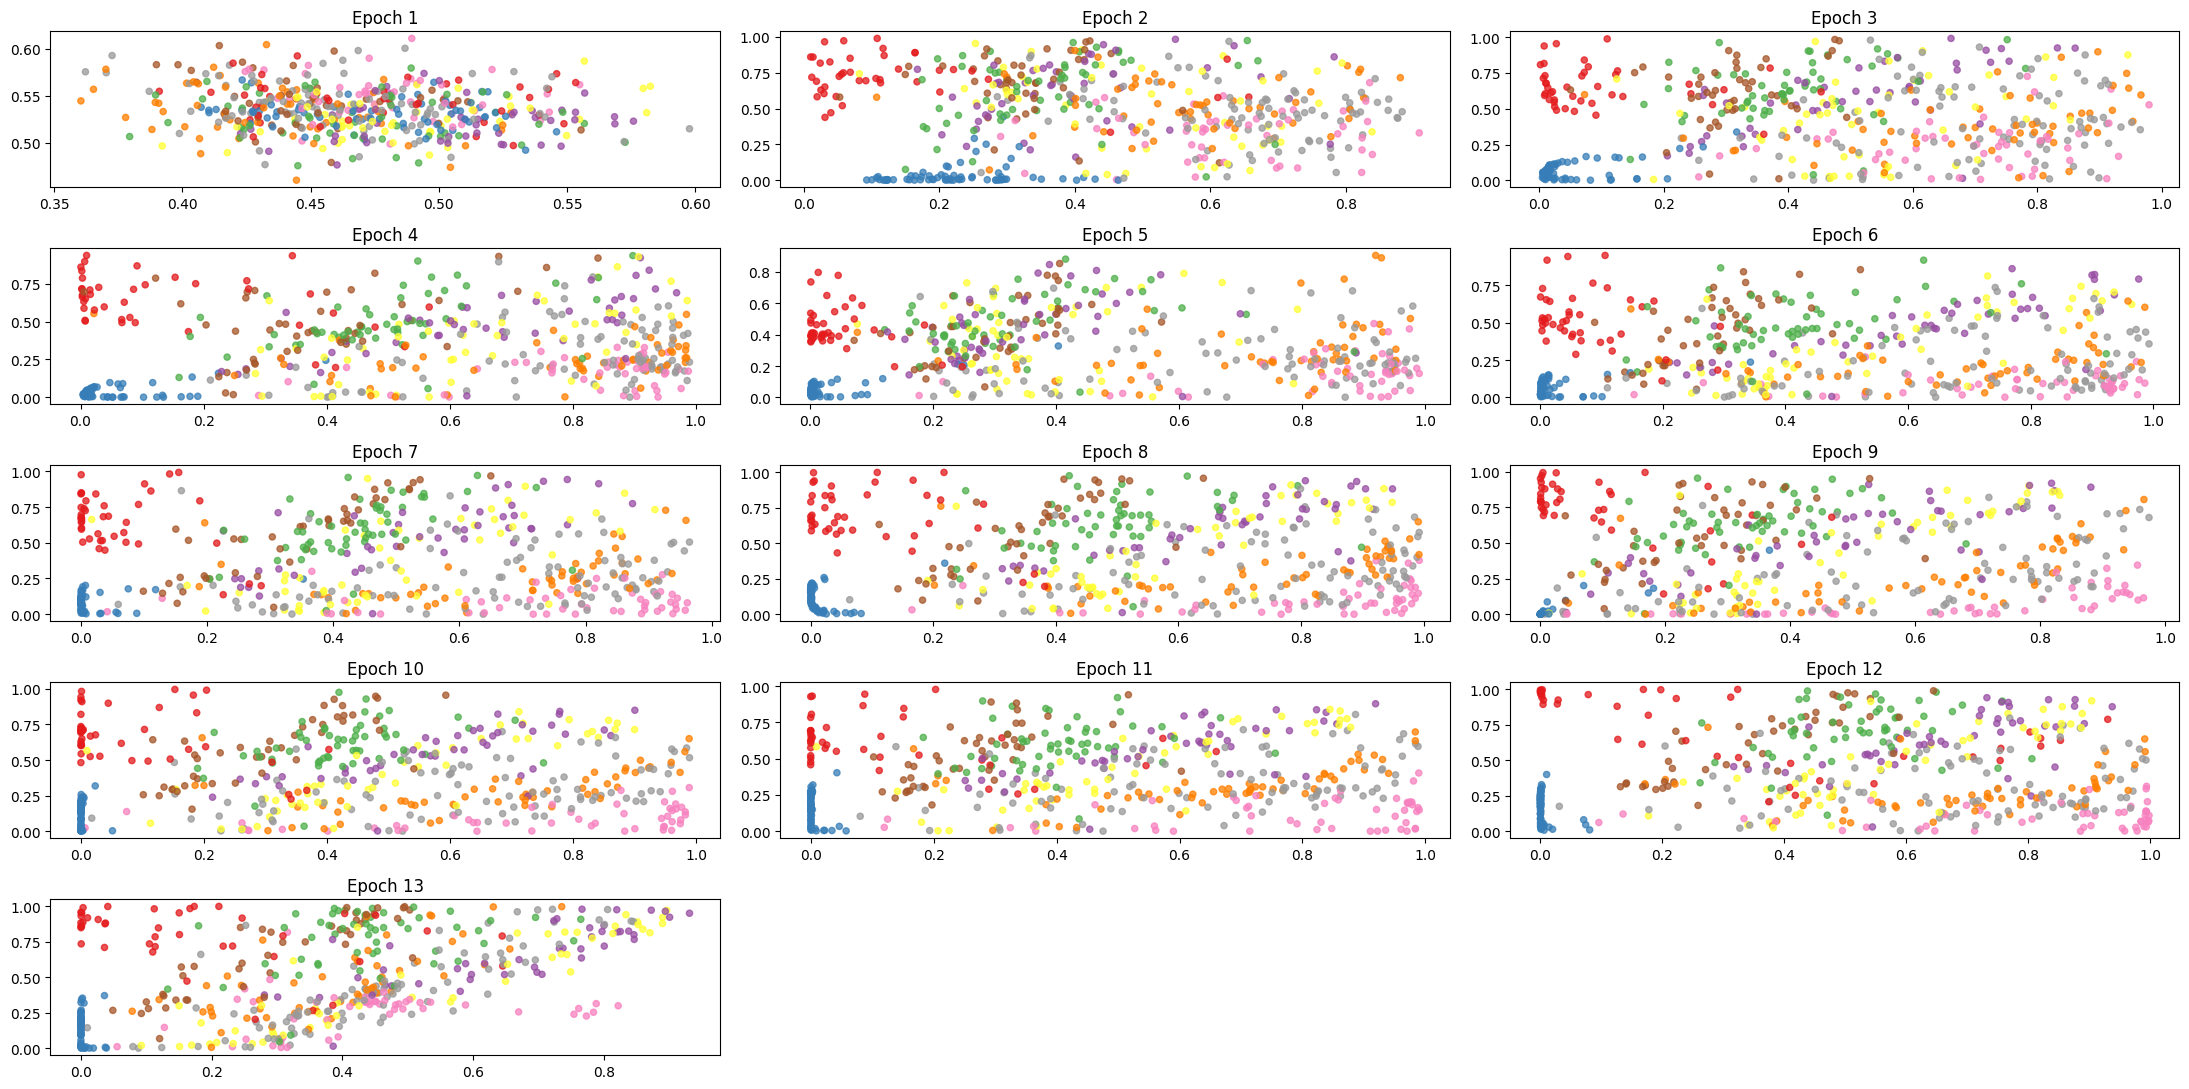

In [ ]:
import matplotlib.pyplot as plt
from itertools import product

rows = 5
cols = 3

fig, axs = plt.subplots(rows,cols, dpi=100, figsize=(4*rows+2,3*cols+2))

for j,(r,c) in enumerate(product(range(rows),range(cols))):
    if j<representaciones.shape[0]:
        axs[r,c].scatter(representaciones[j,:,0], representaciones[j,:,1],c=y_test[0:500],
                        s=20, alpha=0.75, cmap='Set1')
        axs[r,c].set_title(f'Epoch {j+1}')
    else: # Cuando salgamos del rango, dejar en blanco
        axs[r,c].get_xaxis().set_visible(False)
        axs[r,c].get_yaxis().set_visible(False)
        axs[r,c].axis('off')
fig.tight_layout()
fig.show()

⭕ Modifica la arquitectura de la red y los parámetros de entrenamiento para lograr una mejor separación de las clases.

## Opcional: Generemos una animación con estas imágenes

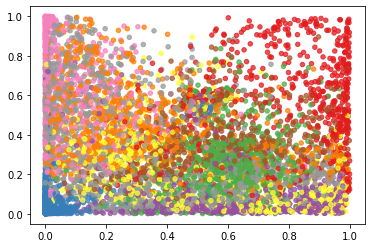

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pylab as pl

num_frames = representaciones.shape[0]

def animate(i): 
    c = axes.scatter(representaciones[i,:,0], representaciones[i,:,1],c=y_test[0:500],
                        s=20, alpha=0.75, cmap='Set1')
    return c

fig, axes = pl.subplots(1, 1) 
anim = animation.FuncAnimation(fig, animate, frames=num_frames)
anim.save('animation.mp4', fps=1, dpi=600)
plt.show()

## ¿Por qué usar autoencoders teniendo PCA, t-SNE, etc..?

* Las redes neuronales permiten una mayor potencia y flexibilidad en la reducción de datos no lineales al variando el número y el tipo de capas utilizadas en las etapas intermedias. Además, eligiendo tipos específicos de funciones de activación en determinadas capas, se puede diseñar la naturaleza de la reducción a las propiedades de los datos.

* Muchos métodos de reducción de dimensionalidad tienen dificultades para tratar con datos no vistos durante el entrenamiento. Por otro lado, es relativamente sencillo asignar puntos pasándolos por la red. Por ejemplo, `t-SNE` no tiene manera de transformar datos no vistos durante el entrenamiento.
